<a href="https://colab.research.google.com/github/Prajan2910/Apparel-and-Clothing-Detection-Using-CNN-and-PyTorch/blob/main/CNN_on_Fashion_MNIST_Dataset1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The project includes the following key components:**

1) **Data Loading and Preprocessing:** The Fashion MNIST dataset is loaded and split into training, validation, and test sets. The images are normalized and transformed into tensors for processing by the neural network.

2) **Model Architecture:** A simple neural network is built using PyTorch's nn.Sequential with layers including fully connected (*linear*) layers, *ReLU* activations, and *dropout* for regularization. The model outputs class probabilities *using LogSoftmax*.

3) **Training and Validation:** The model is trained using the Adam optimizer and negative log likelihood loss (*NLLLoss*). The training and validation losses, as well as validation accuracy, are tracked and printed for each epoch.

4) **Visualization:** The training and validation losses are plotted to observe the model's performance over time. Additionally, the model's predictions on sample images are visualized alongside the predicted class probabilities.

5) **Image Prediction:** Three options are provided to predict images:

6) **Random Image from Dataset:** Use a random image from the Fashion MNIST dataset to predict the class.

7) **Image from URL:** Preprocess and predict the class of an image from a given URL.

In [2]:
#Importing the neccesary modules
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import OrderedDict

# Download training and testing data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
train_ds = datasets.FashionMNIST('F_MNIST_data', download=True, train=True, transform=transform)
test_ds = datasets.FashionMNIST('F_MNIST_data', download=True, train=False, transform=transform)

100%|██████████| 26421880/26421880 [00:02<00:00, 11874699.92it/s]


Extracting F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 217241.94it/s]


Extracting F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3956503.24it/s]


Extracting F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4510607.27it/s]

Extracting F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw



In [3]:
#Splitting for Training and Testing
train_num = len(train_ds)
indices = list(range(train_num))
np.random.shuffle(indices)
split = int(np.floor(0.2 * train_num))
val_idx, train_idx = indices[:split], indices[split:]
len(val_idx), len(train_idx)

(12000, 48000)

torch.Size([1, 28, 28]) torch.Size([64])
Coat


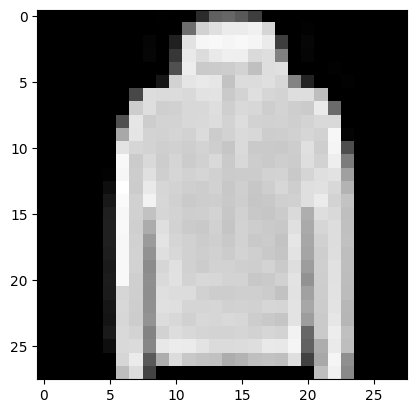

In [4]:
#Prepare Dataloaders
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, sampler=train_sampler)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)
val_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, sampler=val_sampler)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True)

image, label = next(iter(train_dl))
print(image[0].shape, label.shape)

#Classified Items List
desc = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
print(desc[label[0].item()])
plt.imshow(image[0].numpy().squeeze(), cmap='gray');

In [5]:
#Defining the Components for The Network
def network():
    model = nn.Sequential(OrderedDict([('fc1', nn.Linear(784, 128)),
                                       ('relu1', nn.ReLU()),
                                       ('drop1', nn.Dropout(0.25)),
                                       ('fc2', nn.Linear(128, 64)),
                                       ('relu2', nn.ReLU()),
                                       ('drop1', nn.Dropout(0.25)),
                                       ('output', nn.Linear(64, 10)),
                                       ('logsoftmax', nn.LogSoftmax(dim=1))]))
    #Using the GPU
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    #Define the criteria and optimizer
    loss_fn = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0025)

    return model, loss_fn, optimizer, device

In [6]:
#Printing the Model
model, loss_fn, optimizer, device = network()
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [7]:
import torch
import matplotlib.pyplot as plt

#Training and Validating the model, epochs = 32
def train_validate(model, loss_fn, optimizer, trainloader, testloader, device, n_epochs=32):
    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        #Training and Dropouts will be used here
        model.train()
        train_epoch_loss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            #Flattening the size to 784
            images = images.view(images.shape[0], -1)
            #Predicting
            outputs = model(images)
            #Backpropogation
            train_batch_loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            train_batch_loss.backward()
            #Update
            optimizer.step()
            train_epoch_loss += train_batch_loss.item()
        else:
            #One epoch of training complete and calculating average training epoch loss
            train_epoch_loss = train_epoch_loss/len(trainloader)

            #Validating on testset
            with torch.no_grad():
                test_epoch_acc = 0
                test_epoch_loss = 0
                #Evaluation - Dropouts will NOT be used here
                model.eval()
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)
                    #Flattening the size to 784
                    images = images.view(images.shape[0], -1)
                    #Predicting
                    test_outputs = model(images)
                    #Calculating test loss
                    test_batch_loss = loss_fn(test_outputs, labels)
                    test_epoch_loss += test_batch_loss

                    #Getting the class with highest probability
                    proba = torch.exp(test_outputs)
                    _, pred_labels = proba.topk(1, dim=1)

                    #Comparing predicted and actual labels
                    result = pred_labels == labels.view(pred_labels.shape)
                    batch_acc = torch.mean(result.type(torch.FloatTensor))
                    test_epoch_acc += batch_acc.item()
                else:
                    #One epoch of training complete and calculating average training epoch loss
                    test_epoch_loss = test_epoch_loss/len(testloader)
                    #Accuracy = correct_pred/total_samples
                    test_epoch_acc = test_epoch_acc/len(testloader)
                    #Saving epoch losses for plotting
                    train_losses.append(train_epoch_loss)
                    test_losses.append(test_epoch_loss)
                    #Printing stats for this epoch
                    print(f'Epoch: {epoch} -> train_loss: {train_epoch_loss:.19f}, val_loss: {test_epoch_loss:.19f}, ',
                          f'val_acc: {test_epoch_acc*100:.2f}%')

#Plot the training and validation losses
    plt.plot(train_losses, label='train-loss')
    plt.plot(test_losses, label='val-loss')
    plt.legend()
    plt.show()

Epoch: 0 -> train_loss: 0.5776492169102033225, val_loss: 0.4271319508552551270,  val_acc: 84.39%
Epoch: 1 -> train_loss: 0.4509509938955307273, val_loss: 0.3949326872825622559,  val_acc: 85.31%
Epoch: 2 -> train_loss: 0.4157308305899302114, val_loss: 0.3916253447532653809,  val_acc: 85.53%
Epoch: 3 -> train_loss: 0.3966756415466467511, val_loss: 0.3706207275390625000,  val_acc: 86.38%
Epoch: 4 -> train_loss: 0.3842780284484227371, val_loss: 0.3466551899909973145,  val_acc: 87.55%
Epoch: 5 -> train_loss: 0.3747670896848042665, val_loss: 0.3652539849281311035,  val_acc: 86.96%
Epoch: 6 -> train_loss: 0.3600810761650403147, val_loss: 0.3585758507251739502,  val_acc: 86.81%
Epoch: 7 -> train_loss: 0.3487917735576629430, val_loss: 0.3433926403522491455,  val_acc: 87.70%
Epoch: 8 -> train_loss: 0.3403966753681500479, val_loss: 0.3551783859729766846,  val_acc: 87.33%
Epoch: 9 -> train_loss: 0.3419098485211531369, val_loss: 0.3514500558376312256,  val_acc: 87.58%
Epoch: 10 -> train_loss: 0.328

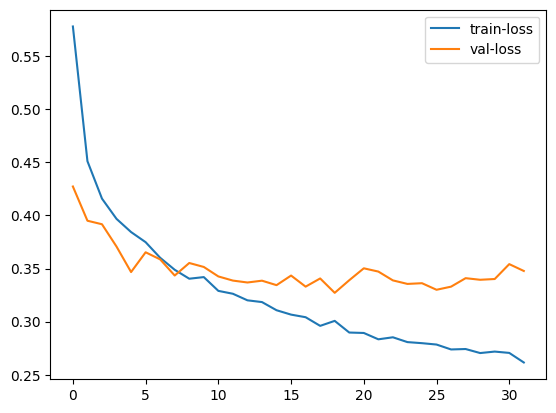

In [8]:
#Training and Validating
train_validate(model, loss_fn, optimizer, train_dl, val_dl, device)

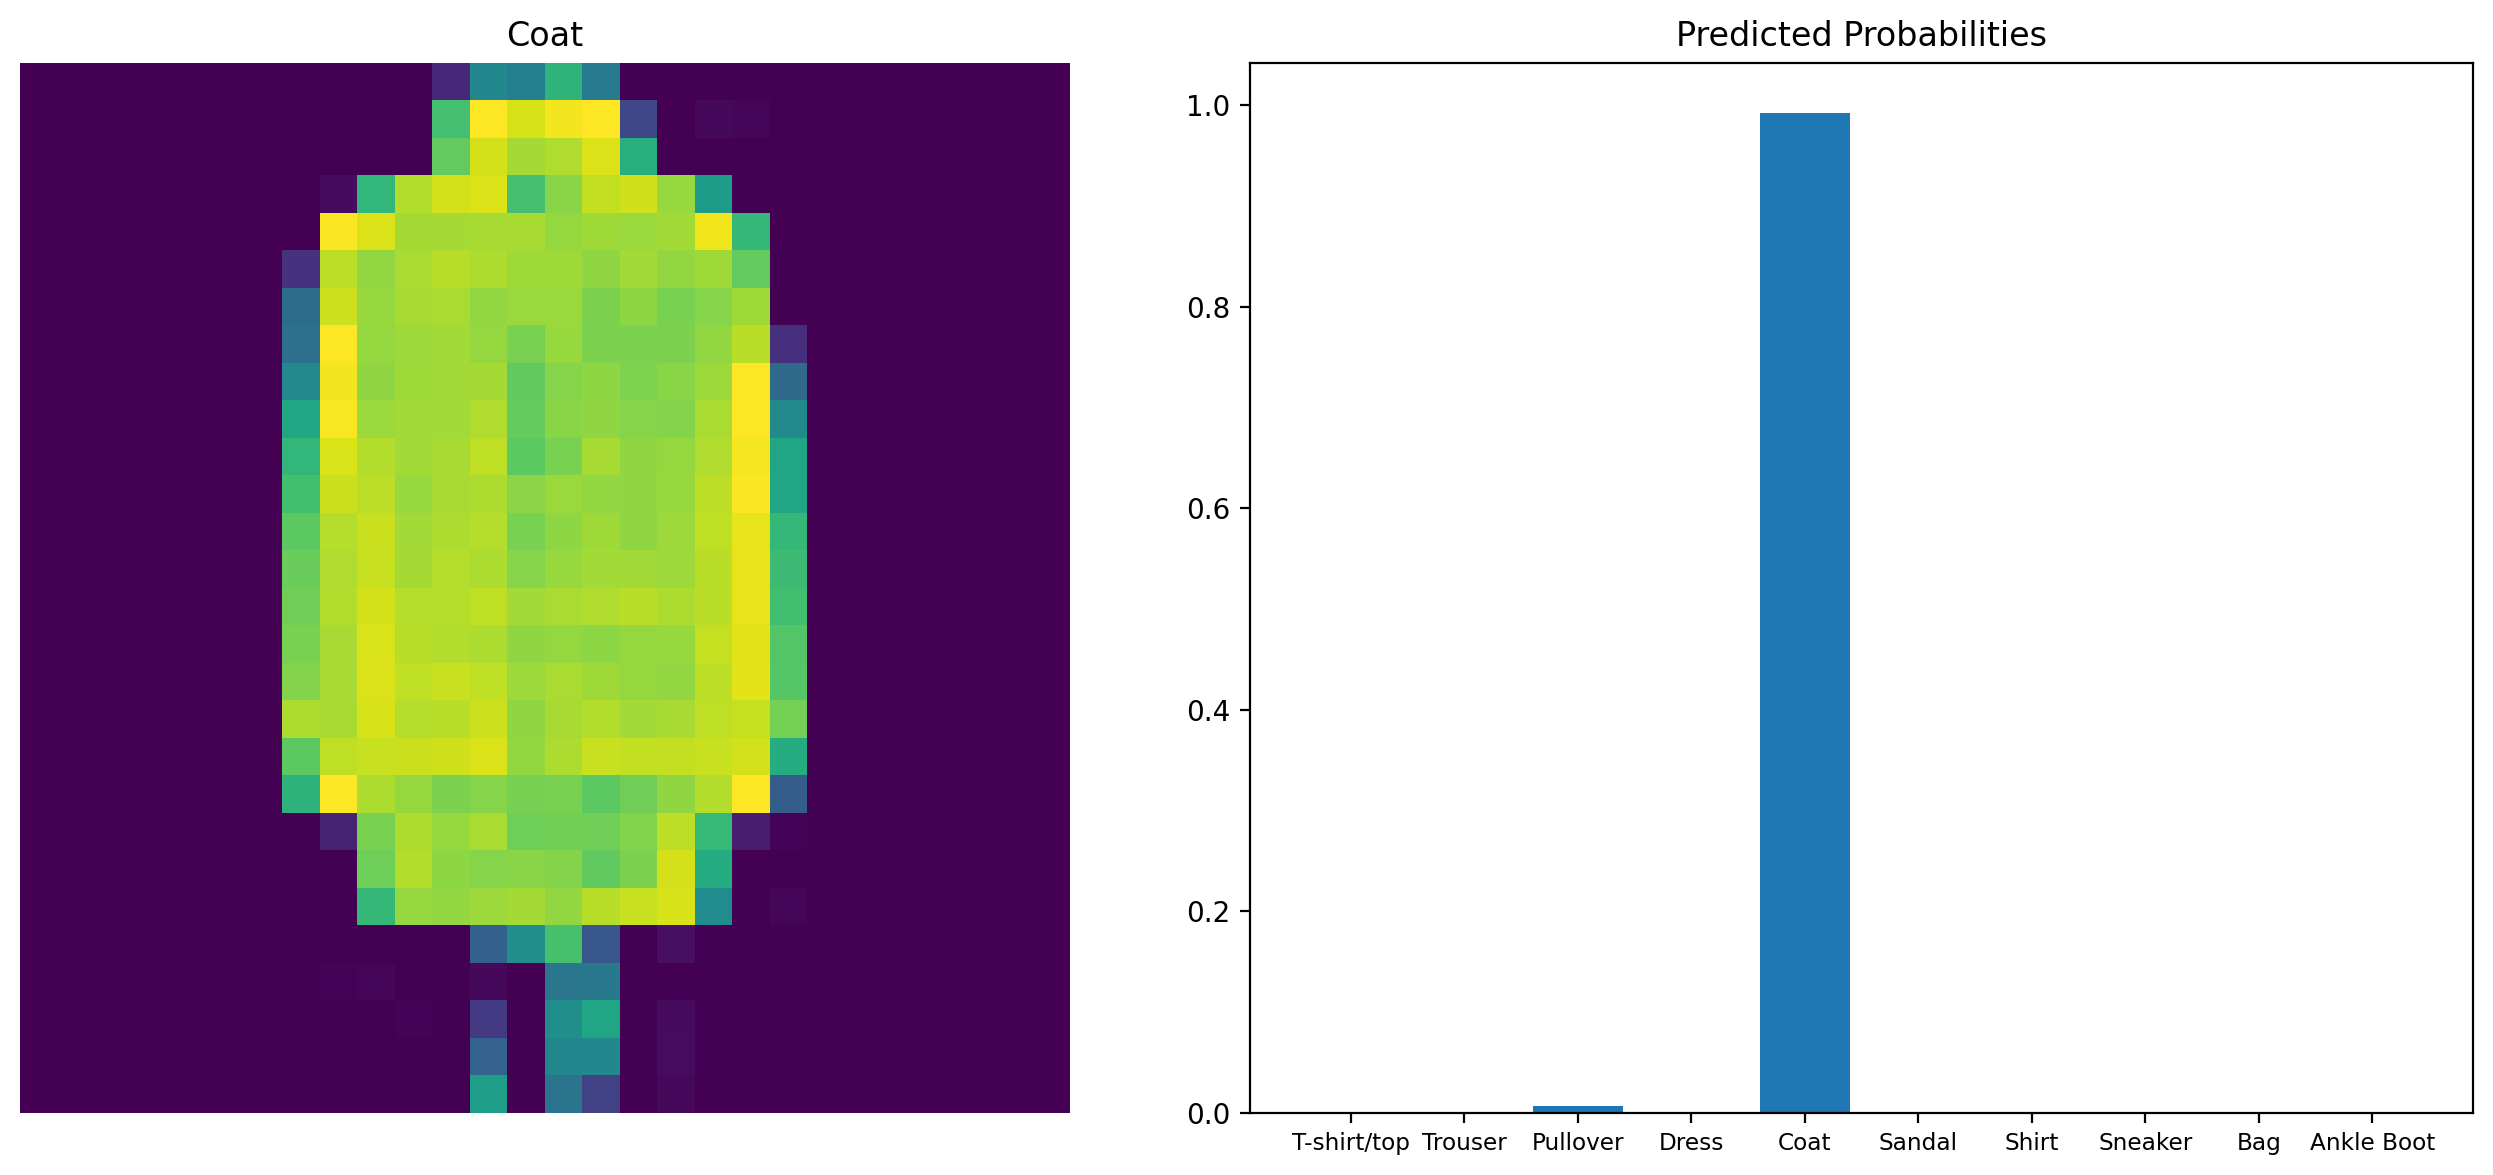

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Testing the Network
dataiter = iter(test_dl)
images, labels = dataiter.__next__()
images, labels = images.to(device), labels.to(device)
index = 49
img, label = images[index], labels[index]
#Convert 2D image to 1D vector
img = img.view(img.shape[0], -1)

#Calculate the class probabilities (softmax) for img
proba = torch.exp(model(img))

#Plot the image and probabilities
desc = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
fig, (ax1, ax2) =  plt.subplots(figsize=(13, 6), nrows=1, ncols=2)
ax1.axis('off')
ax1.imshow(images[index].cpu().numpy().squeeze())
ax1.set_title(desc[label.item()])
ax2.bar(range(10), proba.detach().cpu().numpy().squeeze())
ax2.set_xticks(range(10))
ax2.set_xticklabels(desc, size='small')
ax2.set_title('Predicted Probabilities')
plt.tight_layout()

In [14]:
#Validation
with torch.no_grad():
    batch_acc = []
    model.eval()
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        #Setting images to batch size of x=784
        images = images.view(images.shape[0], -1)
        #Predicting
        proba = torch.exp(model(images))
        #Getting Probabilities and Extracting the class of Highest probability
        _, pred_labels = proba.topk(1, dim=1)
        #Comparing the actual and predicted labels
        result = pred_labels == labels.view(pred_labels.shape)
        acc = torch.mean(result.type(torch.FloatTensor))
        batch_acc.append(acc.item())
    else:
        print(f'Test Accuracy: {torch.mean(torch.tensor(batch_acc))*100:.2f}%')

Test Accuracy: 87.25%


In [15]:
#Redefining Network with More Dropout layers in between
def network():
    model = nn.Sequential(OrderedDict([('fc1', nn.Linear(784, 392)),
                                       ('relu1', nn.ReLU()),
                                       ('drop1', nn.Dropout(0.25)),
                                       ('fc12', nn.Linear(392, 196)),
                                       ('relu2', nn.ReLU()),
                                       ('drop2', nn.Dropout(0.25)),
                                       ('fc3', nn.Linear(196, 98)),
                                       ('relu3', nn.ReLU()),
                                       ('drop3', nn.Dropout(0.25)),
                                       ('fc4', nn.Linear(98, 49)),
                                       ('relu4', nn.ReLU()),
                                       ('output', nn.Linear(49, 10)),
                                       ('logsoftmax', nn.LogSoftmax(dim=1))]))

    #Using the GPU
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    #Define the criteria and optimizer
    loss_fn = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0009)

    return model, loss_fn, optimizer, device

In [16]:
#Loading Redefined Model
model, loss_fn, optimizer, device = network()
model

Sequential(
  (fc1): Linear(in_features=784, out_features=392, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.25, inplace=False)
  (fc12): Linear(in_features=392, out_features=196, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=196, out_features=98, bias=True)
  (relu3): ReLU()
  (drop3): Dropout(p=0.25, inplace=False)
  (fc4): Linear(in_features=98, out_features=49, bias=True)
  (relu4): ReLU()
  (output): Linear(in_features=49, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

Epoch: 0 -> train_loss: 0.6500828417142232585, val_loss: 0.4384387433528900146,  val_acc: 84.17%
Epoch: 1 -> train_loss: 0.4559821867545445495, val_loss: 0.4057640433311462402,  val_acc: 85.82%
Epoch: 2 -> train_loss: 0.4162404372294744026, val_loss: 0.3791009485721588135,  val_acc: 86.51%
Epoch: 3 -> train_loss: 0.3898404167493184636, val_loss: 0.3841929435729980469,  val_acc: 85.93%
Epoch: 4 -> train_loss: 0.3722764532963435125, val_loss: 0.3449352383613586426,  val_acc: 87.34%
Epoch: 5 -> train_loss: 0.3543966199954350915, val_loss: 0.3507640659809112549,  val_acc: 86.92%
Epoch: 6 -> train_loss: 0.3451555942495663776, val_loss: 0.3402990698814392090,  val_acc: 87.29%
Epoch: 7 -> train_loss: 0.3338081060449282211, val_loss: 0.3296075463294982910,  val_acc: 87.95%
Epoch: 8 -> train_loss: 0.3227124283015728179, val_loss: 0.3538372218608856201,  val_acc: 87.21%
Epoch: 9 -> train_loss: 0.3136379232803980233, val_loss: 0.3237664699554443359,  val_acc: 88.48%
Epoch: 10 -> train_loss: 0.309

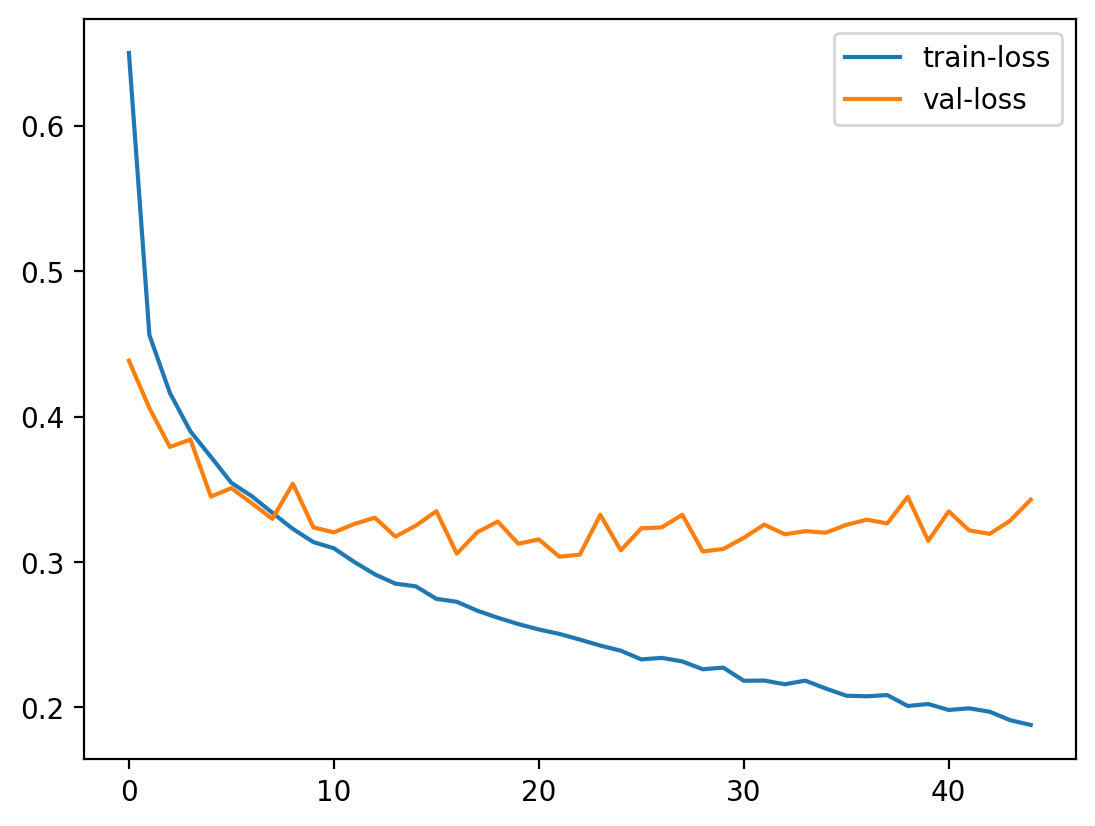

In [17]:
#Training and Validating again with new architecture with 45 epochs
train_validate(model, loss_fn, optimizer, train_dl, val_dl, device, n_epochs=45)

In [18]:
#Validating the Redefined Model
with torch.no_grad():
    model.eval()
    batch_acc = []
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        #Setting images to batch size of x=784
        images = images.view(images.shape[0], -1)
        #Predicting
        proba = torch.exp(model(images))
        #Getting Probabilities and Extracting the class of Highest probability
        _, pred_labels = proba.topk(1, dim=1)
        #Comparing the actual and predicted labels
        result = pred_labels == labels.view(pred_labels.shape)
        acc = torch.mean(result.type(torch.FloatTensor))
        batch_acc.append(acc.item())
    else:
        print(f'Accuracy: {torch.mean(torch.tensor(batch_acc))*100:.2f}%')

Accuracy: 88.70%


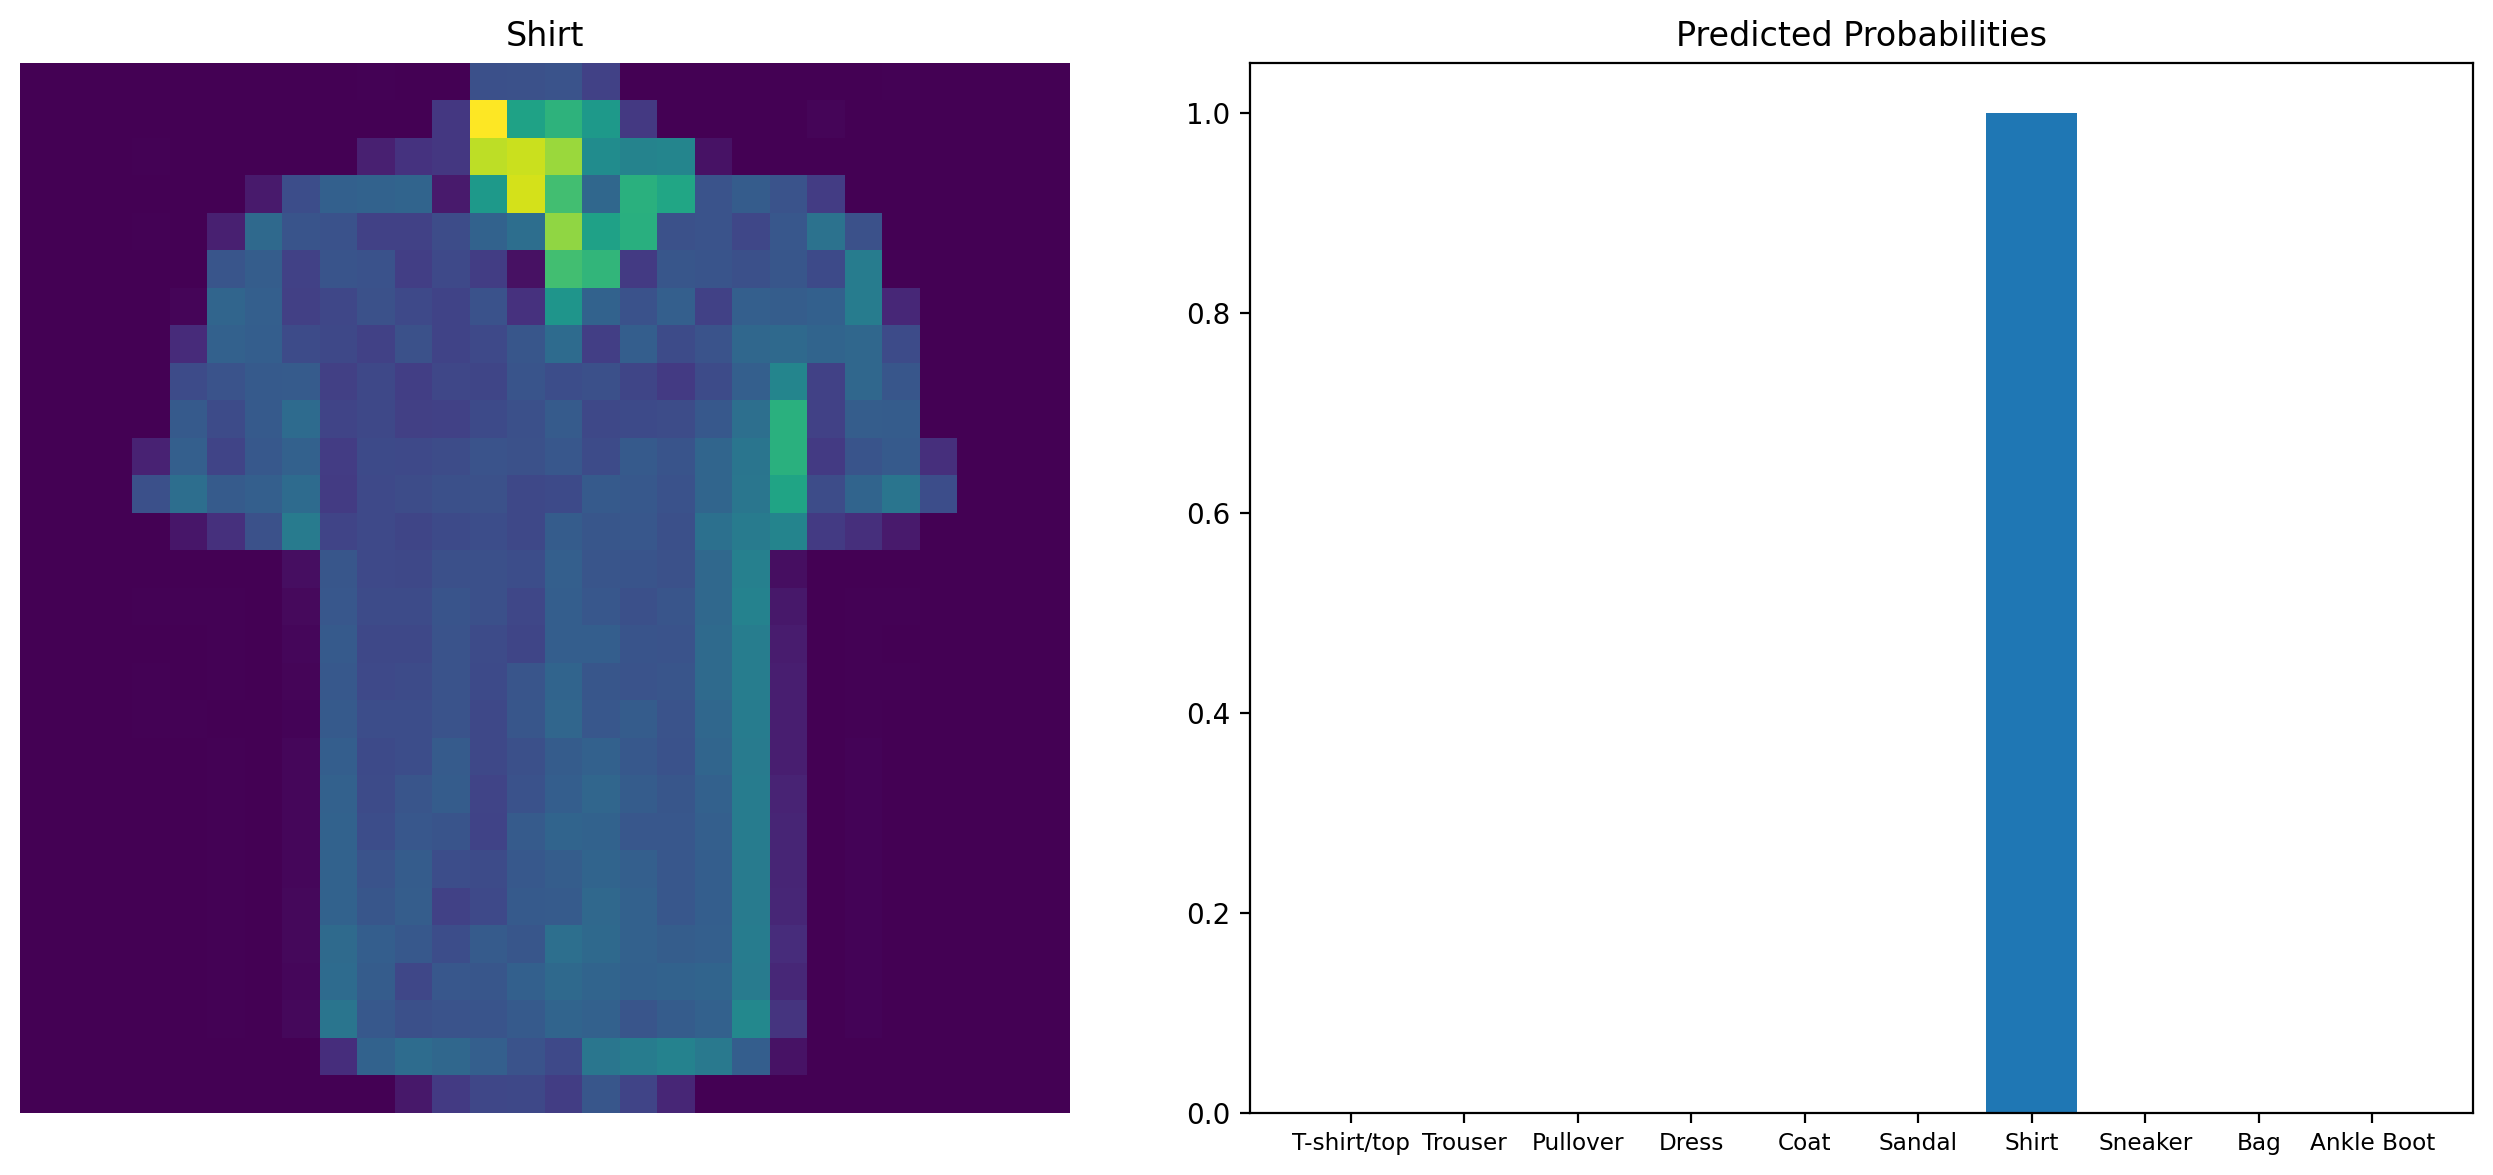

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Test out the network!
dataiter = iter(test_dl)
images, labels = dataiter.__next__()
images, labels = images.to(device), labels.to(device)
index = 49
img, label = images[index], labels[index]
# Convert 2D image to 1D vector
img = img.view(img.shape[0], -1)

# Calculate the class probabilities (softmax) for img
proba = torch.exp(model(img))

# Plot the image and probabilities
desc = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
fig, (ax1, ax2) =  plt.subplots(figsize=(13, 6), nrows=1, ncols=2)
ax1.axis('off')
ax1.imshow(images[index].cpu().numpy().squeeze())
ax1.set_title(desc[label.item()])
ax2.bar(range(10), proba.detach().cpu().numpy().squeeze())
ax2.set_xticks(range(10))
ax2.set_xticklabels(desc, size='small')
ax2.set_title('Predicted Probabilities')
plt.tight_layout()

Enter the image URL: https://gear-rider.com/cdn/shop/products/2O7A3108_1800x1800_525d9af7-19c6-421a-8055-f57c90601ee5.jpg?v=1636484454&width=400


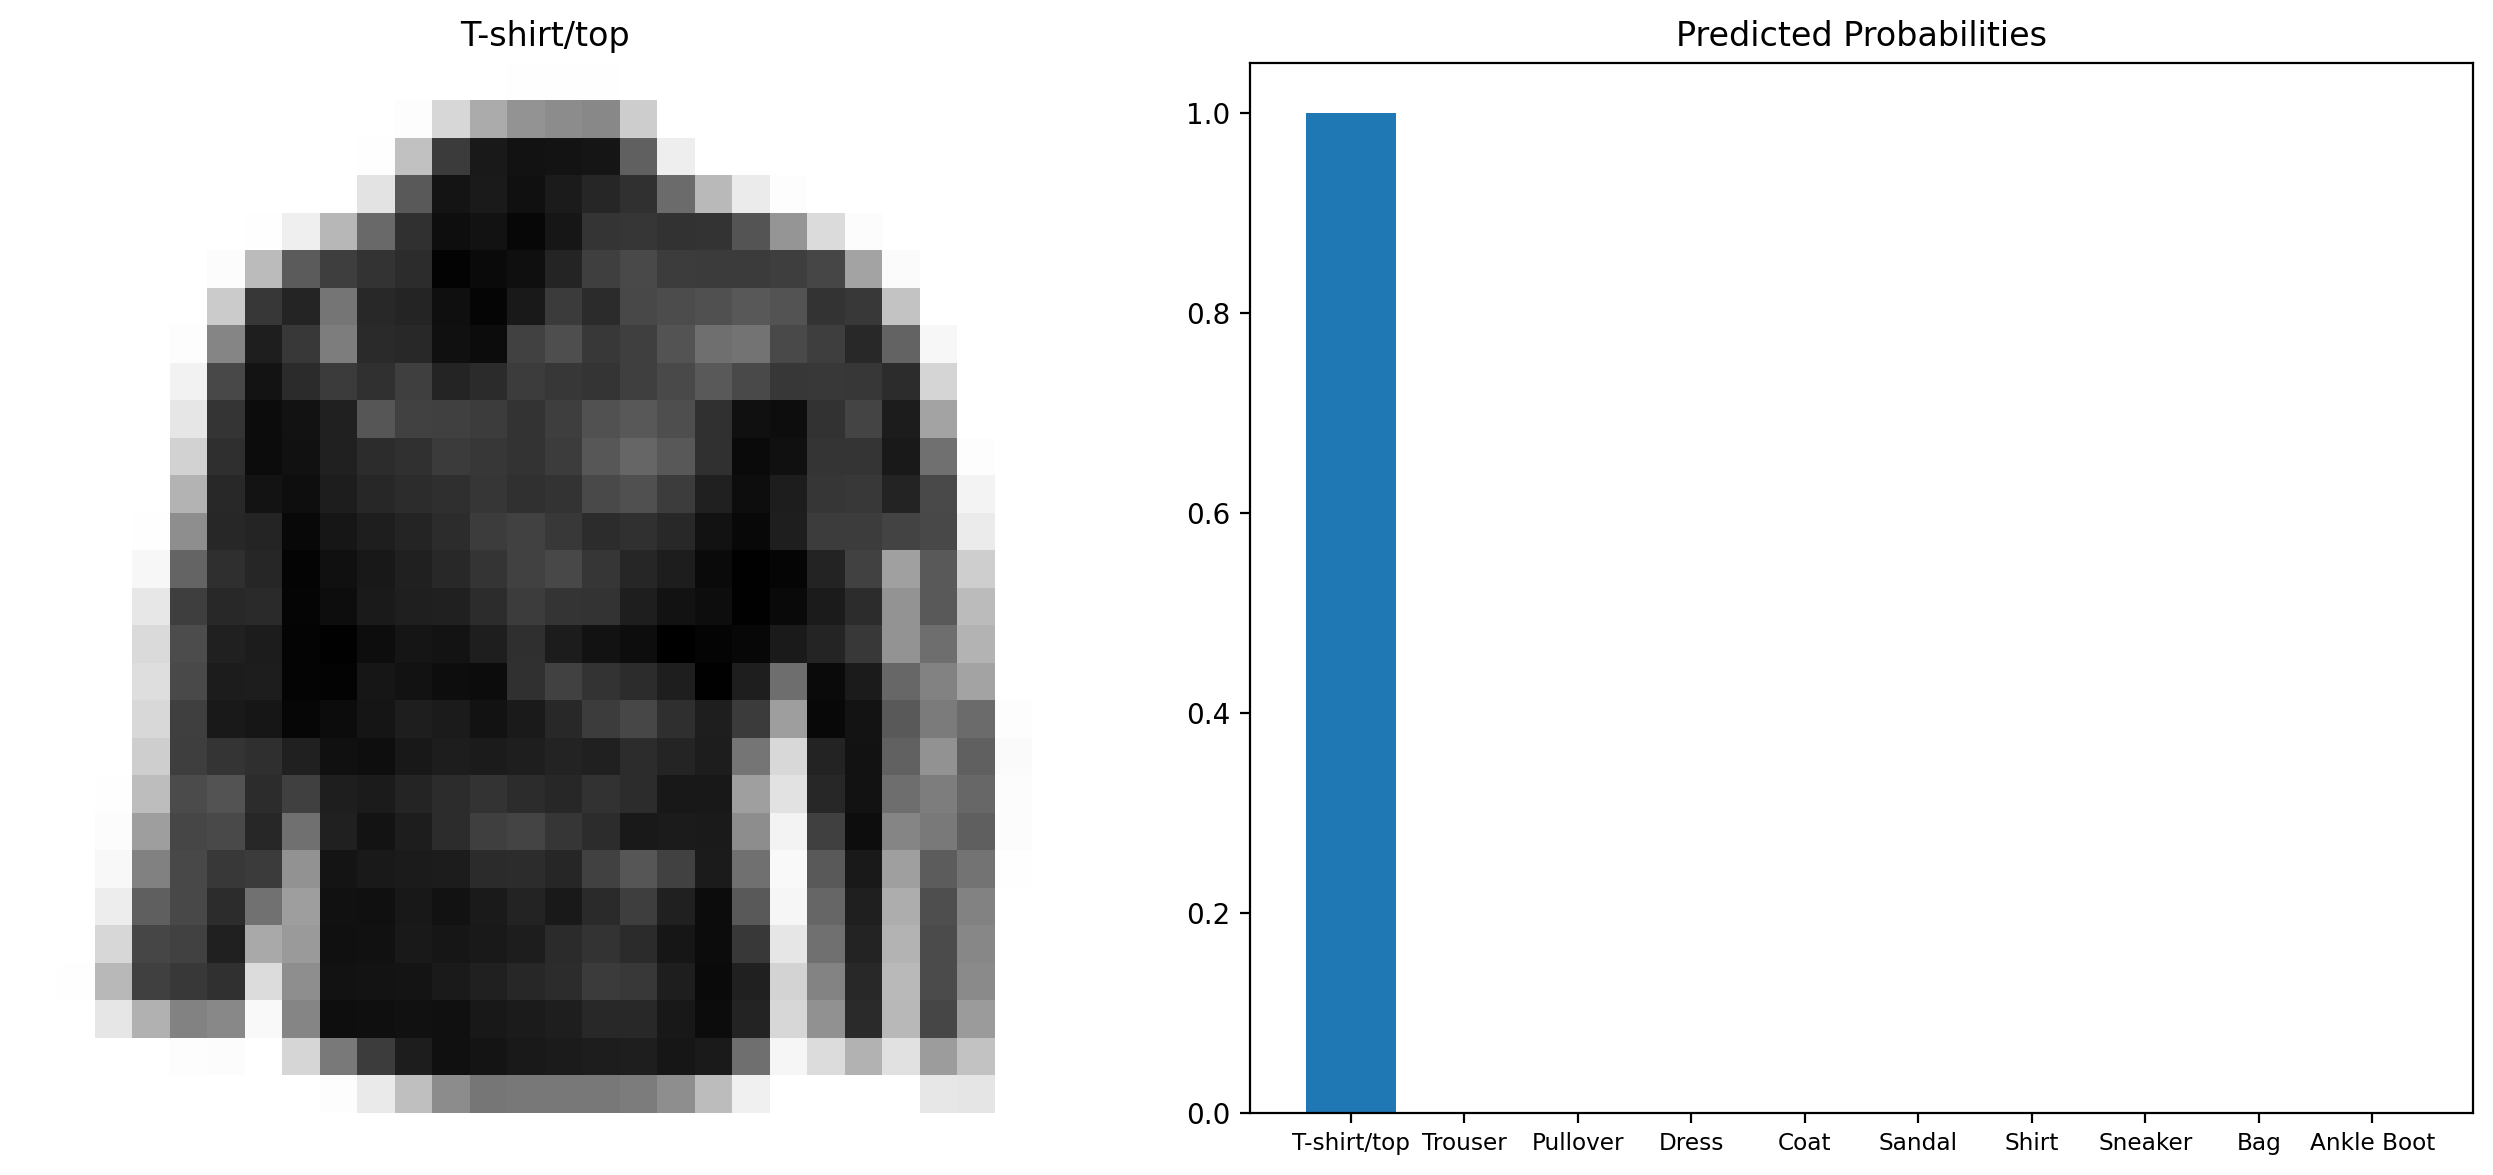

In [21]:
import requests
from PIL import Image
import io
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

# Function to preprocess the image from URL
def preprocess_image_from_url(image_url):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize((28, 28)),                 # Resize to 28x28 pixels
        transforms.ToTensor(),                      # Convert image to tensor
        transforms.Normalize((0.5,), (0.5,))        # Normalize the tensor
    ])

    # Fetch the image from the URL
    try:
        response = requests.get(image_url)
        response.raise_for_status()  # Check for HTTP errors
        image = Image.open(io.BytesIO(response.content)).convert('RGB')
    except requests.RequestException as e:
        print(f"Error fetching image: {e}")
        return None
    except IOError as e:
        print(f"Error opening image: {e}")
        return None

    # Apply the transform to the image
    image_tensor = transform(image)

    # Add a batch dimension (needed for model input)
    image_tensor = image_tensor.unsqueeze(0)  # Shape: [1, 1, 28, 28]

    return image_tensor

# Get the image URL from the user
image_url = input("Enter the image URL: ")

# Preprocess the image
image_tensor = preprocess_image_from_url(image_url)
if image_tensor is None:
    print("Failed to preprocess image.")
else:
        # Predict the class and probabilities
        with torch.no_grad():
            model.eval()  # Set the model to evaluation mode
            image_tensor = image_tensor.to(device)
            image_tensor = image_tensor.view(image_tensor.shape[0], -1)
            proba = torch.exp(model(image_tensor))
            predicted_class = torch.argmax(proba, dim=1).item()

        # Plot the image and probabilities
        desc = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

        fig, (ax1, ax2) = plt.subplots(figsize=(13, 6), nrows=1, ncols=2)

        # Display the image
        ax1.imshow(image_tensor.squeeze().cpu().numpy().reshape(28, 28), cmap='gray')
        ax1.axis('off')
        ax1.set_title(desc[predicted_class])

        # Display the probabilities
        ax2.bar(range(10), proba.squeeze().cpu().numpy())
        ax2.set_xticks(range(10))
        ax2.set_xticklabels(desc, size='small')
        ax2.set_title('Predicted Probabilities')

        plt.tight_layout()
        plt.show()